In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

import warnings
warnings.filterwarnings('ignore')

In [30]:
df = pd.read_excel('datosListos.xlsx', sheet_name='MF')

df.head()

,jobControl,horasComp,NVueltas,NPExternoKit,NPExternoNoKit,NPExternoTotal,NPMS,NPNuevos,NPNuevosKit,NPNuevosNoKit,...,MO_Reparar,MO_End,TrabajoReal_DyE,TrabajoReal_Reparar,TrabajoReal_End,DuracionOS,DemoraOS,pondWorkerIn,CostoTTA,CostoTotal
0,MF,16342,2,0,0,0,0,65,59,6,...,7,3,59.8,98.2,16.0,98,-2,4.192009,251.95,100869.80
1,MF,25225,0,0,2,2,0,65,52,13,...,8,2,60.0,118.5,13.5,100,-1,4.498630,250.90,127101.80
2,MF,15996,1,0,1,1,0,64,56,8,...,7,2,64.5,100.0,16.0,86,-2,4.007306,250.90,118623.02
3,MF,17778,1,0,1,1,0,21,13,8,...,7,3,57.0,97.0,16.0,77,-6,4.796015,250.90,139951.98
4,MF,15049,0,0,1,1,0,17,10,7,...,10,3,60.5,104.0,16.0,81,-8,5.456073,232.82,173308.87


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   jobControl             203 non-null    object 
 1   horasComp              203 non-null    int64  
 2   NVueltas               203 non-null    int64  
 3   NPExternoKit           203 non-null    int64  
 4   NPExternoNoKit         203 non-null    int64  
 5   NPExternoTotal         203 non-null    int64  
 6   NPMS                   203 non-null    int64  
 7   NPNuevos               203 non-null    int64  
 8   NPNuevosKit            203 non-null    int64  
 9   NPNuevosNoKit          203 non-null    int64  
 10  cantKits               203 non-null    int64  
 11  cantNoKits             203 non-null    int64  
 12  costoKits              203 non-null    float64
 13  costoNoKits            203 non-null    float64
 14  cantNParte             203 non-null    int64  
 15  costoN

In [32]:
df.drop(['jobControl',
         'NPExternoTotal',
         'cantNParte',
         'costoNetoRepuestos',
         'NPNuevos',
         'conteoPartesReparadas',
         'costoKits',
         'costoNoKits',
         'CostoTTA',
         'TrabajoReal_DyE',
         'TrabajoReal_Reparar',
         'TrabajoReal_End',
         'cantNoKits',
         'NPExternoKit',
         'DemoraOS',
         'DuracionOS'],axis=1,inplace=True)

In [33]:
DataFrame4 = df

In [34]:
Y=DataFrame4['CostoTotal']
X=DataFrame4.drop(['CostoTotal'],axis=1,inplace=False)

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
x_train, x_test, y_train, y_test = train_test_split(
                                        DataFrame4.drop(columns = "CostoTotal"),
                                        DataFrame4['CostoTotal'],
                                        random_state = 123)

modelo = RandomForestRegressor(
            n_estimators = 5,
            criterion    = 'mse',
            max_depth    = 5,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )


modelo.fit(x_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=5, n_estimators=5, n_jobs=-1,
                      random_state=123)

In [37]:
predicciones = modelo.predict(X = x_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )

In [38]:
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text

In [43]:
param_grid = {'n_estimators': [25,40,50,100],
              'max_features': [3,4,5,8,10],
              'max_depth'   : [3,4,5,6],
             }


grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = -1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = x_train, y = y_train)


resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
66,6,4,50,-36453.788199,4197.469748,-20300.206884,935.785118
67,6,4,100,-36490.990867,4146.556100,-20089.686510,826.997104
63,6,3,100,-36491.611323,4032.167974,-20521.889697,836.562782
62,6,3,50,-36534.772243,3850.641768,-20733.716636,863.622675
61,6,3,40,-36605.727783,3817.549801,-20811.959266,929.763526


In [44]:
print("Mejores parámetros encontrados: ")
print("                                ")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

Mejores parámetros encontrados: 
                                
{'max_depth': 6, 'max_features': 4, 'n_estimators': 50} : -36453.78819863098 neg_root_mean_squared_error


In [45]:
modelo_final = grid.best_estimator_
predicciones = modelo.predict(X = x_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 37414.88393442104


In [46]:
importancia_predictores = pd.DataFrame(
                            {'predictor': DataFrame4.drop(columns = "CostoTotal").columns,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo:")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo:


,predictor,importancia
6,cantKits,0.237542
3,NPMS,0.199574
4,NPNuevosKit,0.116819
7,MO_DyE,0.080702
10,pondWorkerIn,0.075187
0,horasComp,0.073102
1,NVueltas,0.064529
2,NPExternoNoKit,0.063432
5,NPNuevosNoKit,0.058111
9,MO_End,0.021129


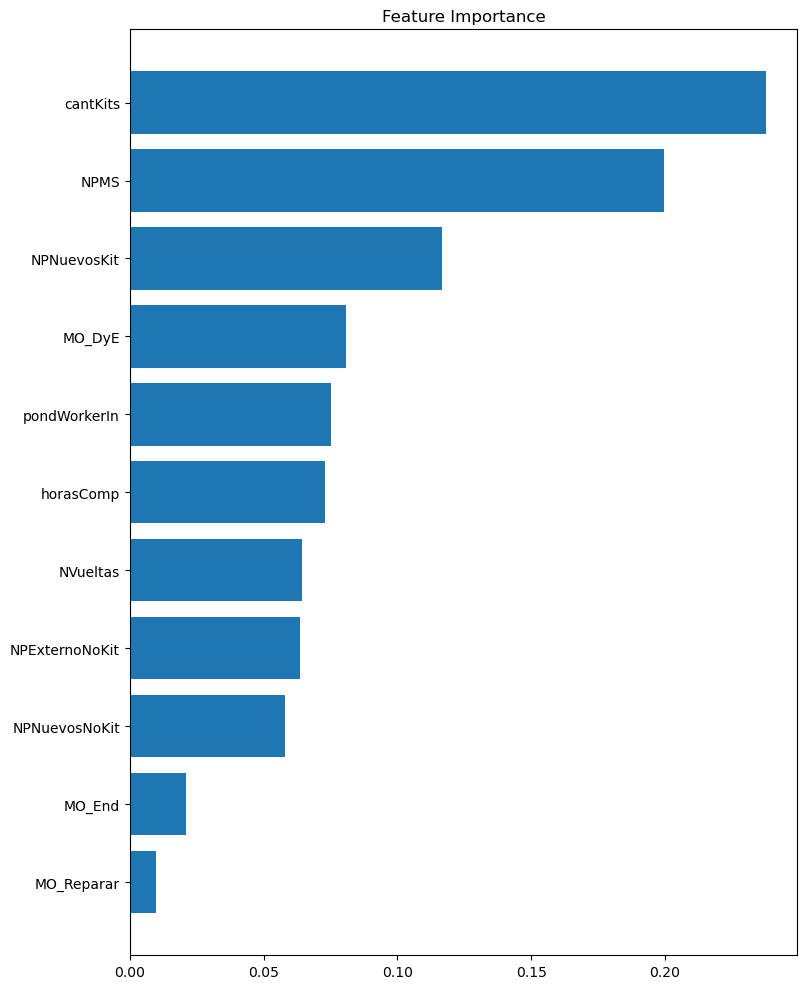

In [47]:
feature_names = DataFrame4.drop(columns = "CostoTotal").columns
feature_importance = modelo.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance")

fig.tight_layout()
plt.show()
fig.savefig('ResultadosMF.png')

In [48]:
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = x_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = -1,
                random_state = 123
             )

df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = x_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
7,5543.737416,820.418226,MO_DyE
4,4216.426990,237.116503,NPNuevosKit
0,4196.794106,319.922185,horasComp
6,4099.096203,575.328938,cantKits
3,4093.928816,720.158634,NPMS
2,3659.378539,382.339901,NPExternoNoKit
5,2994.413719,290.460363,NPNuevosNoKit
10,2112.918104,256.514785,pondWorkerIn
1,1684.314871,173.237008,NVueltas
8,1053.359375,137.315835,MO_Reparar


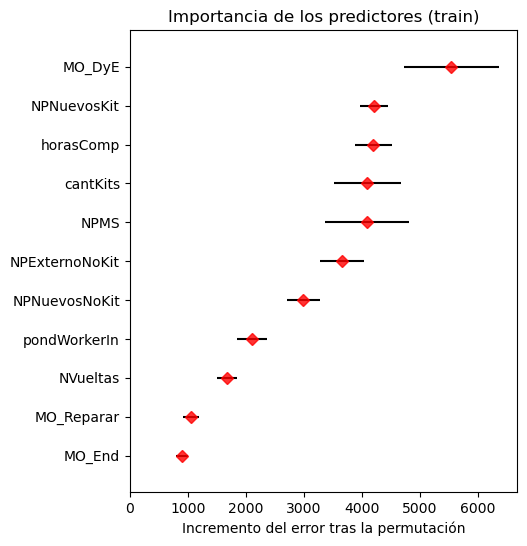

In [49]:
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

In [ ]:
fig = plt.figure(figsize=(55, 10))
plot_tree(modelo.estimators_[1], 
          feature_names = DataFrame4.drop(columns = "CostoTotal").columns,
          class_names= 'CostoTotal',
          filled        = True,
          impurity      = False,
          fontsize      = 12,
          precision     = 2,)

fig.savefig('img/RandomForestMF.png')